Importing dependencies

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

Loading the dataframes

In [4]:
df_train = pd.read_pickle('../data/processed/df_train.pkl')
df_test = pd.read_pickle('../data/processed/df_test.pkl')
df_val = pd.read_pickle('../data/processed/df_val.pkl')

save_path = Path('../data/processed/')
with open(save_path / 'y_train.pkl' ,'rb') as f:
    y_train = pickle.load(f)
with open(save_path / 'y_test.pkl' ,'rb') as f:
    y_test = pickle.load(f)
with open(save_path / 'y_val.pkl','rb') as f:
    y_val = pickle.load(f)

# Linear Regression

We will implement the linear regression using the normal equation.
* for a given feature vector xi = (xi1,xi2,...,xin) where n = number of features and m = number of records
* y_pred = f(xi) = f(xi1,xi2,..,xin) = w0 + sum(wj*xij){j:1->n}
* w = (w1,..,wn) and xi = (xi1,...,xin)
* To make it easier, we can add the bias term w0 to w and xi0=1 to x
* Now, w = (w0,...,wn) and xi = (1,..,xin)
* We use the vectorized form to compute it
* f(xi) = xi.T.dot(w)
* To find the parameters w, we use the normal equation 

In [5]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    
    

Now to predict the price, we can opt for a Baseline solution; each time we add a set of features and define a metric to see how our model performs.

In [6]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

Right now we have a dataframe and not a matrix, also we need to deal with missing values (we can simply ignore features that have missing values)

In [ ]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values # transforming a dataframe to a matrix
    return X

In [8]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train,y_train)

Now we can simply calculate the prediction using the vectorized form

In [9]:
y_pred = w_0 + X_train.dot(w)

Text(0.5, 1.0, 'Predictions vs actual distribution')

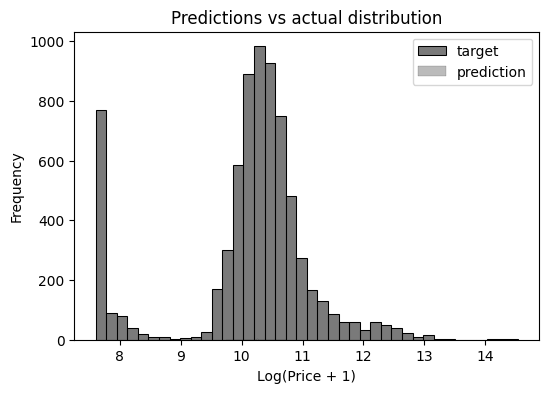

In [37]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.savefig('../plots/predictions_vs_actual_distribution(5 features)')
plt.title('Predictions vs actual distribution')

Visually we can see that our predictions are far from the real values (Note we only used 5 features)

Evaluating model quality using RMSE (root mean squared error)

In [11]:
def rmse(y,y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [12]:
rmse(y_train,y_pred)

0.7554192603920132

We can also use it on the validation set

In [13]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [14]:
rmse(y_val,y_pred)

0.7616530991301603

Feature Engineering

We will add the age feature. (Note that we compare it to 2017 because the dataset was created that year)

In [15]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [16]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.5175055465840046
validation 0.5172055461058318


Conclusion: after adding this feature, the model performed better. We can also check it visually.

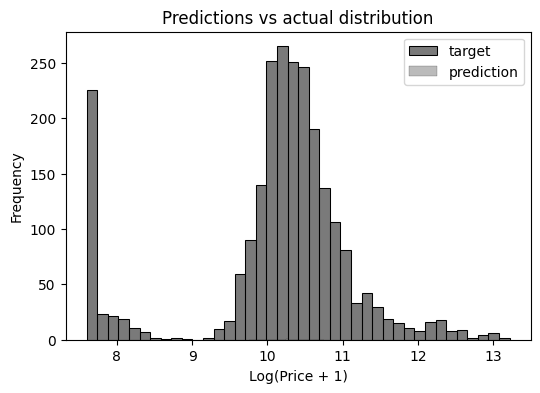

In [38]:
plt.figure(figsize=(6, 4))


sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.savefig('../plots/predictions_vs_actual_distribution(more features).png')
plt.title('Predictions vs actual distribution')

plt.show()

Handling Categorical variables
* We will now look at how other features might affect our predictions (number of doors and the make of the car)
* Note that we are implementing One-hot encoding for each categorical feature

In [18]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [19]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.5058876515487503
validation: 0.5076038849555264


Conclusion: we managed to improve the RMSE score further

Let's now add other features and see the results.

In [20]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [21]:

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 27.179423497531644
validation: 18.474245638356216


we can see that adding other features made the score a lot worse. This is due to numerical instability.The term (X.T.dot(X)) becomes non invertible in the normal equation, which can cause the model parameters w to grow very large.
* This numerical instability can be cause by inter-dependent features
* This can be corrected using Regularization

## Regularization

In [24]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

Here we added some values(r*I; I is the identity matrix) on the diagonal of the matrix (X.T.dotX) to make sure it becomes invertible. The values are controlled by a constant r which we will find the best value by using grid search.

In [25]:
X_train = prepare_X(df_train)

In [26]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, -6449461550616219.00, -1.46, 6449461550617254.00
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


Here we can conclude That r = 0.01 is the best param to stop the parameters w from growing large.

In [27]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.46431248945534853
val 0.46023949634107747


We can also use grid search on r to select the best value that minimizes RMSE score

In [30]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46022494492363214
0.0001 0.46022548796556073
 0.001 0.4602267631468646
  0.01 0.46023949634107747
   0.1 0.46037006958243754
     1 0.4618298042652747
     5 0.46840796275301805
    10 0.4757248100697067


In [31]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.46023949634107747
test: 0.4571813679582453


Conclusion: using Regularization, we scored better than before.

## Using the model

Suppose we have an ad of a car and we need to predict its price

In [32]:
ad = {
 'city_mpg': 18,
 'driven_wheels': 'all_wheel_drive',
 'engine_cylinders': 6.0,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 268.0,
 'highway_mpg': 25,
 'make': 'toyota',
 'market_category': 'crossover,performance',
 'model': 'venza',
 'number_of_doors': 4.0,
 'popularity': 2031,
 'transmission_type': 'automatic',
 'vehicle_size': 'midsize',
 'vehicle_style': 'wagon',
 'year': 2013
} 


In [33]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)

we made a small dataframe df_test containing only one row with the ad values, then we got the matrix X_test

In [35]:
y_pred = w_0 + X_test.dot(w)

In [36]:
suggestion = np.expm1(y_pred)
suggestion

array([28294.13593031])

The predicted price is 28,300 $